In [3]:
import numpy as np
import pandas as pd
import uuid
import pickle
import torch
from IPython.display import display


%load_ext autoreload
%autoreload 2

from vpop_calibration import *

## Define a reference ODE model


In [4]:
# Define the reference PK model we will use for training the GP and generating a synthetic data set
def equations(t, y, k_a, k_12, k_21, k_el):
    # y[0] is A_absorption, y[1] is A_central, y[2] is A_peripheral
    A_absorption, A_central, A_peripheral = y[0], y[1], y[2]
    dA_absorption_dt = -k_a * A_absorption
    dA_central_dt = (
        k_a * A_absorption + k_21 * A_peripheral - k_12 * A_central - k_el * A_central
    )
    dA_peripheral_dt = k_12 * A_central - k_21 * A_peripheral

    ydot = [dA_absorption_dt, dA_central_dt, dA_peripheral_dt]
    return ydot


variable_names = ["A0", "A1", "A2"]
parameter_names = ["k_a", "k_12", "k_21", "k_el"]

ode_model = OdeModel(equations, variable_names, parameter_names)
print(ode_model.variable_names)
time_span = (0, 24)
nb_steps = 10
time_steps = np.linspace(time_span[0], time_span[1], nb_steps).tolist()

protocol_design = pd.DataFrame({"protocol_arm": ["arm-A", "arm-B"], "k_el": [0.5, 10]})
nb_protocols = len(protocol_design)

initial_conditions = np.array([10.0, 0.0, 0.0])

['A0', 'A1', 'A2']


## Train or load an existing GP surrogate


In [5]:
model_file = "gp_surrogate_pk_model.pkl"
folder_path = "./"

model_full_path = folder_path + model_file

use_pickle = False
override_existing_pickle = False

In [34]:
if (override_existing_pickle) or (not use_pickle):
    # Simulate a training data set using parameters sampled via Sobol sequences
    log_nb_patients = 9
    param_ranges = {
        "k_12": {"low": -2.0, "high": 0.0, "log": True},
        "k_21": {"low": -2.0, "high": 0.0, "log": True},
        "k_a": {"low": -2.0, "high": 0.0, "log": True},
    }

    print(f"Simulating {2**log_nb_patients} patients on {nb_protocols} scenario arms")
    dataset = simulate_dataset_from_ranges(
        ode_model,
        log_nb_patients,
        param_ranges,
        initial_conditions,
        protocol_design,
        None,
        None,
        time_steps,
    )

    learned_ode_params = list(param_ranges.keys())
    descriptors = learned_ode_params + ["time"]

    # Instantiate a GP
    myGP = GP(
        dataset,
        descriptors,
        var_strat="IMV",  # either IMV (Independent Multitask Variational) or LMCV (Linear Model of Coregionalization Variational)
        kernel="RBF",  # Either RBF or SMK
        deep_kernel=True,
        data_already_normalized=False,  # default
        nb_inducing_points=100,
        mll="ELBO",  # default, otherwise PLL
        nb_training_iter=200,
        training_proportion=0.7,
        learning_rate=0.1,
        lr_decay=0.99,
        jitter=1e-6,
        nb_features=10,
        nb_latents=3,
        log_inputs=learned_ode_params,
        log_outputs=variable_names,
    )
    # Train the GP
    myGP.train()

    if use_pickle and override_existing_pickle:
        with open(model_full_path, "wb") as file:
            pickle.dump(myGP, file)
        print(f"Model saved to {model_file}")
elif use_pickle and (not override_existing_pickle):
    try:
        with open(model_full_path, "rb") as file:
            myGP = pickle.load(file)

        print("Model loaded successfully!")

    except FileNotFoundError:
        print(
            f"File not found. Please make sure '{model_full_path}' exists and is in the correct directory."
        )

Simulating 512 patients on 2 scenario arms
Successfully loaded a training data set with 512 patients. The following outputs are available:
['A0', 'A1', 'A2']
 and the following protocol arms:
['arm-A', 'arm-B']


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

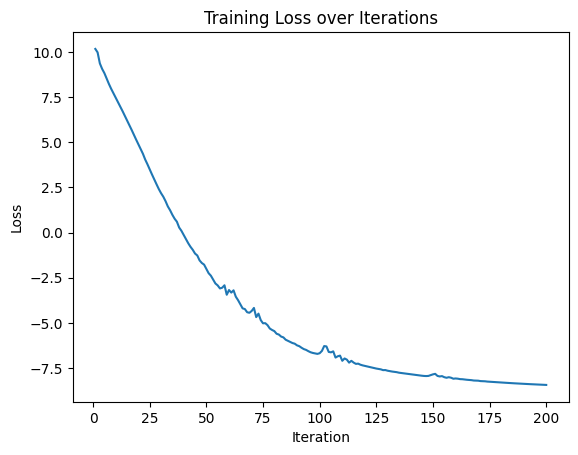

In [35]:
myGP.plot_loss()

## Generate a synthetic data set using a NLME from the ODEs directly


In [36]:
time_span_rw = (0, 24)
nb_steps_rw = 10

# For each output and for each patient, give a list of time steps to be simulated
time_steps_rw = np.linspace(time_span_rw[0], time_span_rw[1], nb_steps_rw).tolist()

# Parameter definitions
true_log_MI = {}
true_log_PDU = {"k_12": {"mean": -1.0, "sd": 0.25}, "k_21": {"mean": -1.0, "sd": 0.25}}
error_model_type = "additive"
true_res_var = [0.1, 0.1, 0.1]
true_covariate_map = {
    "k_12": {"foo": {"coef": "cov_foo_k12", "value": 1.0}},
    "k_21": {},
}

# Create a patient data frame
# It should contain at the very minimum one `id` per patient
nb_patients = 100
patients_df = pd.DataFrame({"id": [str(uuid.uuid4()) for _ in range(nb_patients)]})
rng = np.random.default_rng()
patients_df["protocol_arm"] = rng.binomial(1, 0.5, nb_patients)
patients_df["protocol_arm"] = patients_df["protocol_arm"].apply(
    lambda x: "arm-A" if x == 0 else "arm-B"
)
patients_df["k_a"] = rng.lognormal(-1, 0.1, nb_patients)
patients_df["foo"] = rng.lognormal(0, 0.1, nb_patients)
display(patients_df)

print(f"Simulating {nb_patients} patients on {nb_protocols} protocol arms")
obs_df = simulate_dataset_from_omega(
    ode_model,
    protocol_design,
    time_steps,
    initial_conditions,
    true_log_MI,
    true_log_PDU,
    error_model_type,
    true_res_var,
    true_covariate_map,
    patients_df,
)

display(obs_df)

,id,protocol_arm,k_a,foo
0,faccae46-ce4a-4987-89d3-99f2abf87dad,arm-A,0.401280,1.059675
1,8caecee0-8033-48d8-a8ea-a437d4ca746d,arm-A,0.363803,0.933424
2,9a502515-6830-41dd-a240-cf5afa2d9e29,arm-B,0.362309,0.929920
3,775e7e55-7dd8-4099-9c24-5a04cad48299,arm-B,0.320579,1.049525
4,9b34f4e6-18b3-4048-95fa-9f8e9a823870,arm-A,0.389365,1.142117
...,...,...,...,...
95,b10c4cbe-28b0-4bcc-8541-9f33cdaa31db,arm-A,0.387638,1.062637
96,ce80c26b-6e52-48d9-ab69-1cd7d9dab919,arm-B,0.307447,0.906794
97,9dd8812d-2804-4960-9a0f-5dfb5cc5b046,arm-A,0.345922,1.002822
98,77edd218-76fd-4081-b324-9ebadace92c3,arm-B,0.419583,1.102589


Simulating 100 patients on 2 protocol arms
Successfully loaded 1 covariates:
['foo']
Successfully loaded 1 known descriptors:
['k_a']


,k_12,k_21,k_a,id,protocol_arm,output_name,time,A0_0,A1_0,A2_0,k_el,value
0,0.401280,0.926419,0.420822,faccae46-ce4a-4987-89d3-99f2abf87dad,arm-A,A0,0.000000,10.0,0.0,0.0,0.5,10.000000
1,0.401280,0.926419,0.420822,faccae46-ce4a-4987-89d3-99f2abf87dad,arm-A,A0,2.666667,10.0,0.0,0.0,0.5,3.255652
2,0.401280,0.926419,0.420822,faccae46-ce4a-4987-89d3-99f2abf87dad,arm-A,A0,5.333333,10.0,0.0,0.0,0.5,1.059927
3,0.401280,0.926419,0.420822,faccae46-ce4a-4987-89d3-99f2abf87dad,arm-A,A0,8.000000,10.0,0.0,0.0,0.5,0.345076
4,0.401280,0.926419,0.420822,faccae46-ce4a-4987-89d3-99f2abf87dad,arm-A,A0,10.666667,10.0,0.0,0.0,0.5,0.112345
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.386918,1.567429,0.381421,f604b3e4-2476-456c-8051-2462e75721a1,arm-A,A2,13.333333,10.0,0.0,0.0,0.5,0.070428
2996,0.386918,1.567429,0.381421,f604b3e4-2476-456c-8051-2462e75721a1,arm-A,A2,16.000000,10.0,0.0,0.0,0.5,0.030968
2997,0.386918,1.567429,0.381421,f604b3e4-2476-456c-8051-2462e75721a1,arm-A,A2,18.666667,10.0,0.0,0.0,0.5,0.013210
2998,0.386918,1.567429,0.381421,f604b3e4-2476-456c-8051-2462e75721a1,arm-A,A2,21.333333,10.0,0.0,0.0,0.5,0.005512


## Optimize the GP surrogate using SAEM


In [57]:
# Initial pop estimates
# Parameter definitions
init_log_MI = {}
init_log_PDU = {
    "k_21": {"mean": -0.5, "sd": 0.5},
    "k_12": {"mean": -0.8, "sd": 0.5},
}
error_model_type = "additive"
init_res_var = [0.5, 0.5, 0.5]
init_covariate_map = {
    "k_12": {"foo": {"coef": "cov_foo_k12", "value": 1.0}},
    "k_21": {},
}

# Create a structural model
structural_gp = StructuralGp(myGP)
# Create a NLME moedl
nlme_surrogate = NlmeModel(
    structural_gp,
    patients_df,
    init_log_MI,
    init_log_PDU,
    init_res_var,
    init_covariate_map,
    error_model_type,
)
obs_df_bootstrapped = obs_df.sample(frac=0.8)
# Create an optimizer: here we use SAEM
optimizer = PySaem(
    nlme_surrogate,
    obs_df_bootstrapped,
    nb_phase1_iterations=10,
    nb_phase2_iterations=10,
    mcmc_nb_transitions=1,
    verbose=False,
)

Successfully loaded 1 covariates:
['foo']
Successfully loaded 1 known descriptors:
['k_a']
torch.Size([23, 6]) torch.Size([25, 6]) torch.Size([25, 1])
torch.Size([24, 6]) torch.Size([26, 6]) torch.Size([26, 1])
torch.Size([25, 6]) torch.Size([27, 6]) torch.Size([27, 1])
torch.Size([25, 6]) torch.Size([26, 6]) torch.Size([26, 1])
torch.Size([20, 6]) torch.Size([22, 6]) torch.Size([22, 1])
torch.Size([22, 6]) torch.Size([22, 6]) torch.Size([22, 1])
torch.Size([20, 6]) torch.Size([22, 6]) torch.Size([22, 1])
torch.Size([22, 6]) torch.Size([25, 6]) torch.Size([25, 1])
torch.Size([27, 6]) torch.Size([29, 6]) torch.Size([29, 1])
torch.Size([21, 6]) torch.Size([22, 6]) torch.Size([22, 1])
torch.Size([20, 6]) torch.Size([23, 6]) torch.Size([23, 1])
torch.Size([24, 6]) torch.Size([24, 6]) torch.Size([24, 1])
torch.Size([26, 6]) torch.Size([27, 6]) torch.Size([27, 1])
torch.Size([23, 6]) torch.Size([23, 6]) torch.Size([23, 1])
torch.Size([23, 6]) torch.Size([25, 6]) torch.Size([25, 1])
torch.Siz

In [53]:
%%prun -s cumulative
optimizer.run()

Phase 1 (exploration):


  0%|          | 0/10 [00:00<?, ?it/s]

Phase 2 (smoothing):


  0%|          | 0/10 [00:00<?, ?it/s]

         425788 function calls (409707 primitive calls) in 4.589 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      2/1    0.000    0.000    4.587    4.587 {built-in method builtins.exec}
       99    0.001    0.000    4.582    0.046 base_events.py:1970(_run_once)
       20    0.004    0.000    4.304    0.215 saem.py:278(one_iteration)
       25    0.012    0.000    4.010    0.160 nlme.py:616(mh_step)
       25    0.026    0.001    3.993    0.160 nlme.py:485(log_posterior_etas)
       25    0.002    0.000    3.760    0.150 nlme.py:408(predict_outputs_from_theta)
       25    0.010    0.000    3.660    0.146 structural_model.py:2(simulate)
       25    0.147    0.006    3.600    0.144 gp.py:371(predict_wide_scaled)
       25    0.001    0.000    3.438    0.138 gp.py:352(predict_wide)
       25    0.000    0.000    3.107    0.124 approximate_gp.py:111(__call__)
       25    0.000    0.000    3.107    0.124 independent_mu

In [25]:
optimizer.continue_iterating(nb_add_iters_ph1=10, nb_add_iters_ph2=10)

Continuing phase 1 (exploration):


  0%|          | 0/20 [00:00<?, ?it/s]

Switching to Phase 2 (smoothing)


  0%|          | 0/10 [00:00<?, ?it/s]

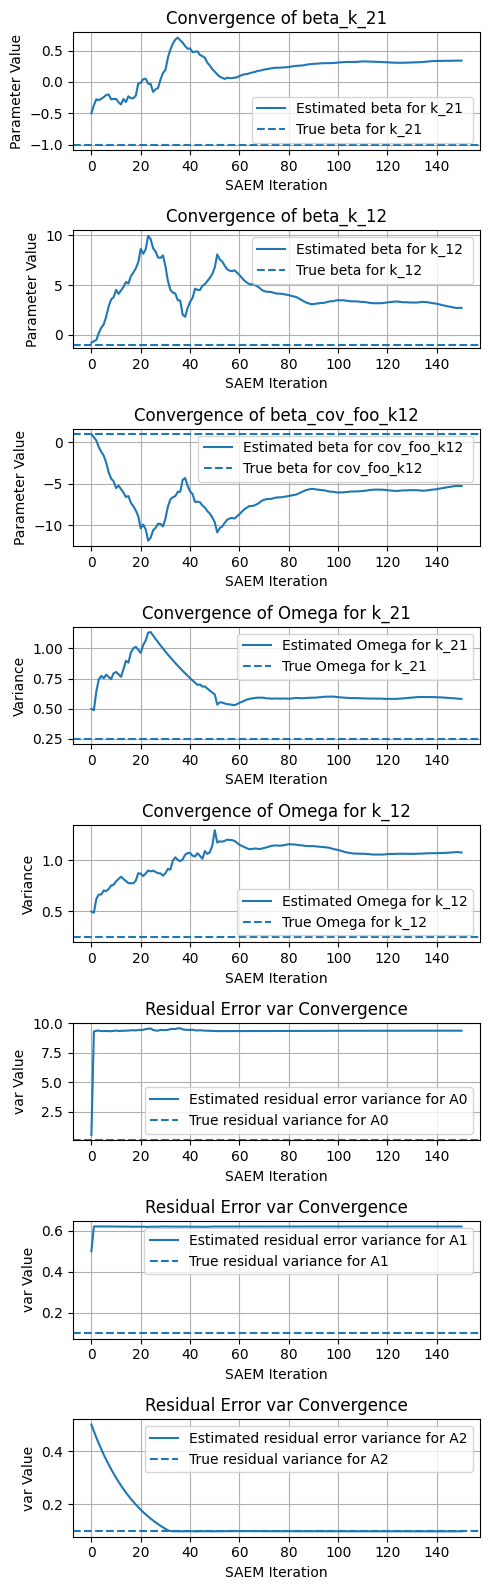

In [50]:
true_MI = {name: np.exp(val) for name, val in true_log_MI.items()}
true_mus = {name: val["mean"] for name, val in true_log_PDU.items()}
true_sd = {name: val["sd"] for name, val in true_log_PDU.items()}
true_covs = {
    str(cov["coef"]): float(cov["value"])
    for item in true_covariate_map.values()
    for cov in item.values()
}
true_betas = true_mus | true_covs
true_sigmas = {
    name: float(true_res_var[j]) for j, name in enumerate(ode_model.variable_names)
}

optimizer.plot_convergence_history(
    true_MI=true_MI,
    true_betas=true_betas,
    true_sd=true_sd,
    true_residual_var=true_sigmas,
)

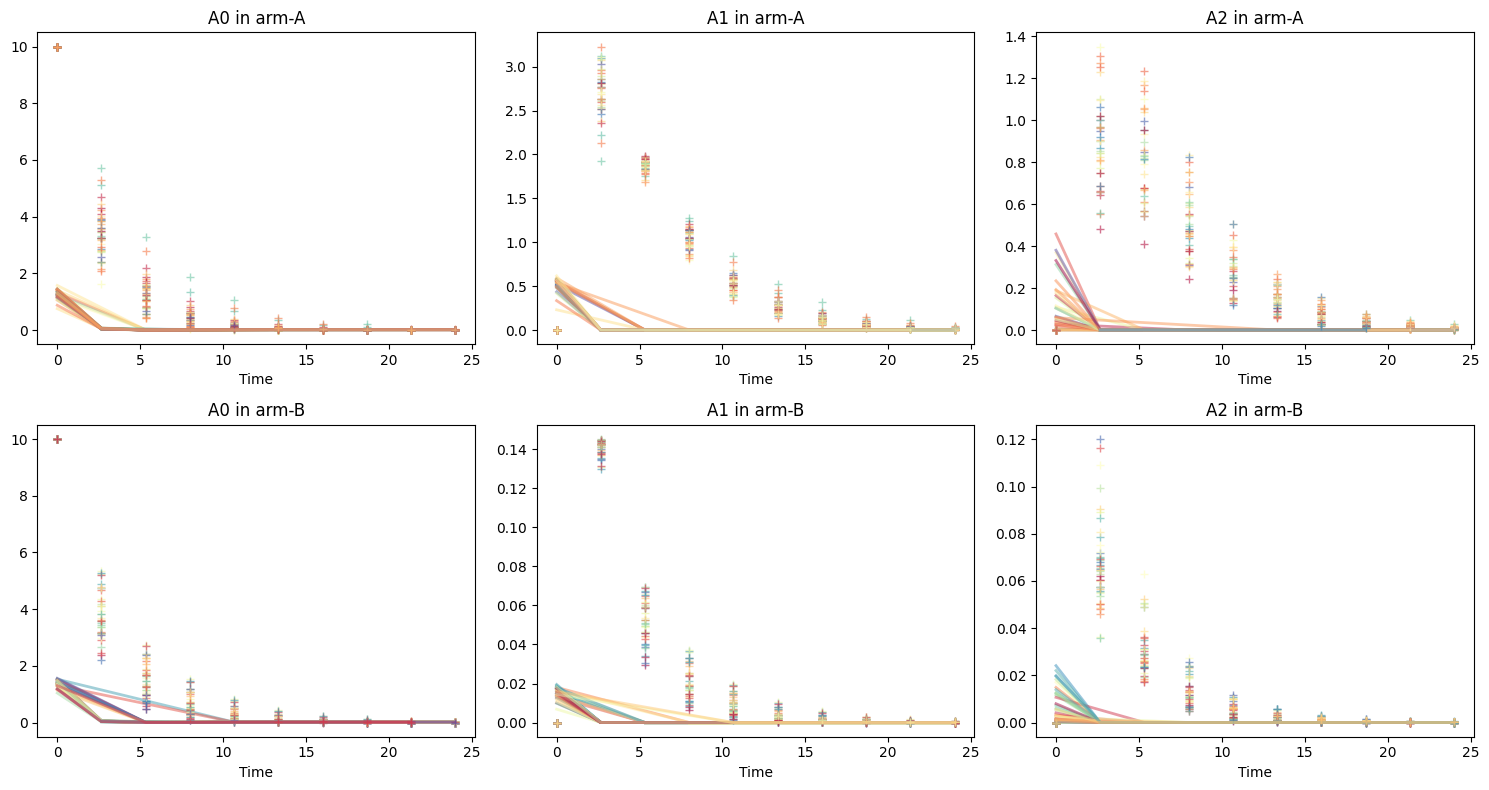

In [51]:
optimizer.plot_map_estimates()